# 5.4 컨브넷 학습 시각화

- Convnet은 시각적인 개념을 학습한 것이기에 시각화하기 아주 좋음
- 따라서 딥러닝에서 말하는 블랙박스라는 개념은 Convnet에는 해당되지 않음

### Convnet의 유용한 시각화 기법 3가지
1. 중간층의 출력(활성화)을 시각화하기
   - 연속된 Convnet 층이 입력을 어떻게 변형시키는지 이해할 수 있음
   

2. 필터를 시각화하기
    - 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 이해할 수 있음
    
    
3. 클래스 활성화에 대한 heatmap을 이미지에 시각화
    - 이미지의 어느 부분이 classification에 기여했는지 이해
    - 이미지에서 객체의 위치를 추정(localization)하는데 도움

## 5.4.1 중간층의 출력(활성화) 시각화하기

### 중간층의 출력(활성화) 시각화
- 어떤 입력이 주어졌을 때 합성곱과 풀링층이 출력하는 **feature map을 그리는 것**
- 층의 출력이 활성화 함수의 출력이라서 활성화(activation)라고도 부름
- 각 채널별로 독립적인 특성을 인코딩하므로 **채널별로 2D 이미지로 시각화** 하는것이 좋은 방법
    - (width, height, ***channel(depth)***)

In [1]:
# 5.2절에서 학습시킨 모델 이용

from keras.models import load_model

model = load_model('./datasets/cats_and_dogs/small/saved_models/cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

(1, 150, 150, 3)


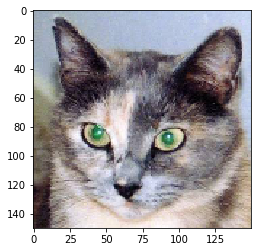

In [2]:
# 입력에 사용할 사진 가져오기

img_path = './datasets/cats_and_dogs/small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

# reshape로 아래와 같이 할 수도 있음
# img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

### Sequential API와 Functional API

- Sequential API
    - layer-by-layer
    - 여러 입력, 출력 모델을 만드는데 제한이 있음
    
    
- Functional API (7장에서 더 자세히 다룸)
    - 모델은 만드는데 더욱 유연함
    - 여러 입력, 출력 모델을 만들 수 있음

In [3]:
# Functional API를 사용해 합성곱 기반 층 모두를 출력하는 모델 만들기

from keras import models

# 상위 8개 층 : 합성곱 기반 층 (Conv + Pooling)
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)

activation_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0   

In [4]:
# 전체 출력(활성화)
activations = activation_model.predict(img_tensor)
print("전체 출력(활성화) 수 :", len(activations))

# 첫번째 feature map
first_layer_activation = activations[0]
print("첫번째 feature map 텐서 :", first_layer_activation.shape)

전체 출력(활성화) 수 : 8
첫번째 feature map 텐서 : (1, 148, 148, 32)


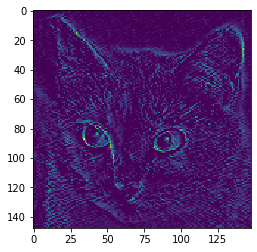

In [5]:
import matplotlib.pyplot as plt

# 첫번째 feature map의 20번째 채널 가시화
plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')

/home/young/anaconda3/envs/tf_2.0/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


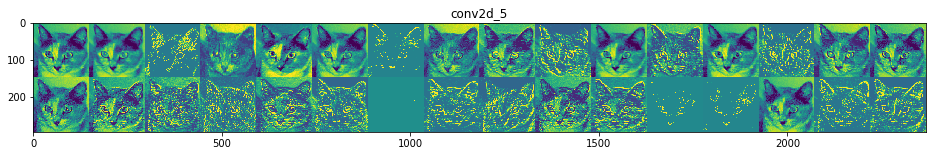

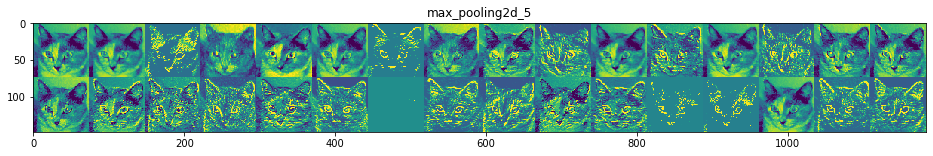

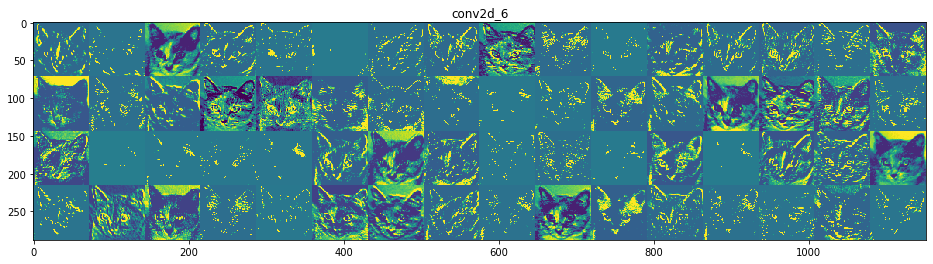

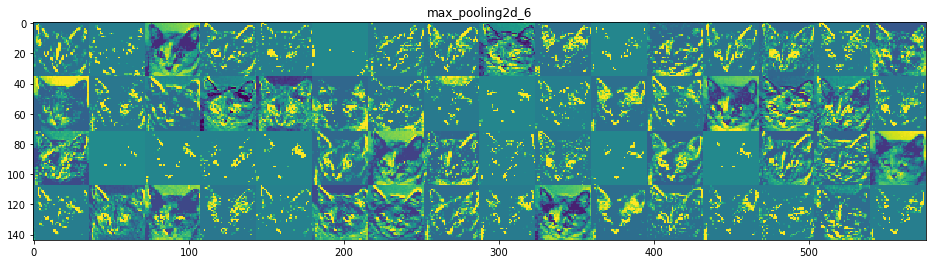

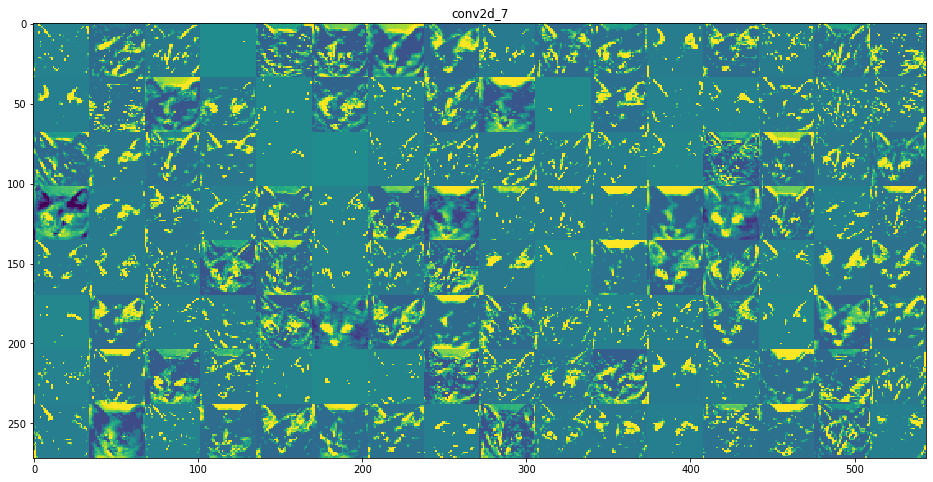

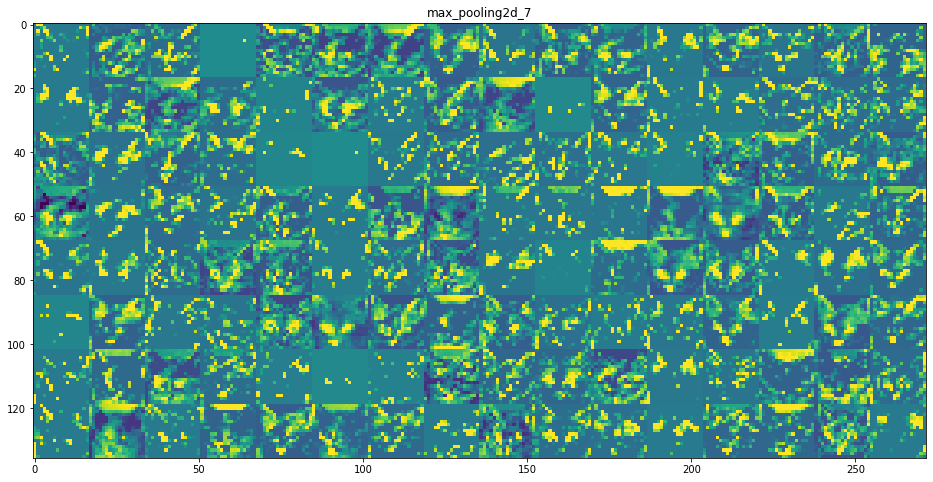

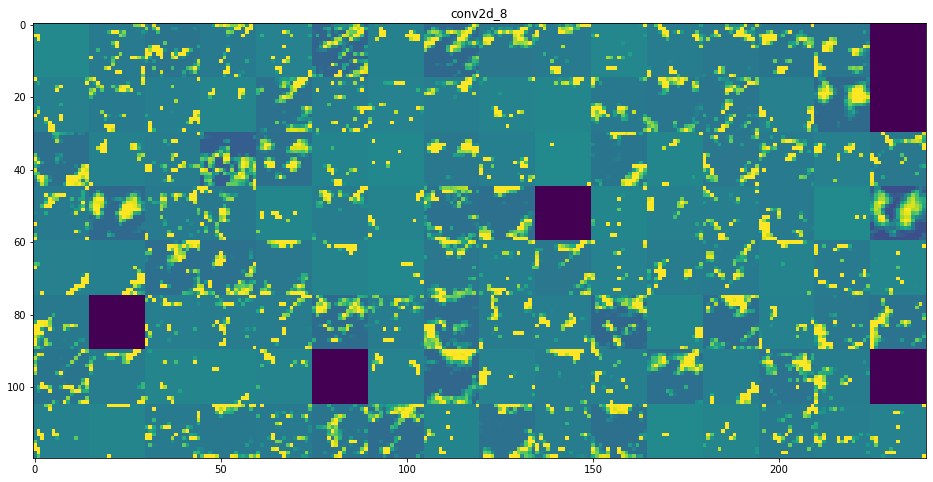

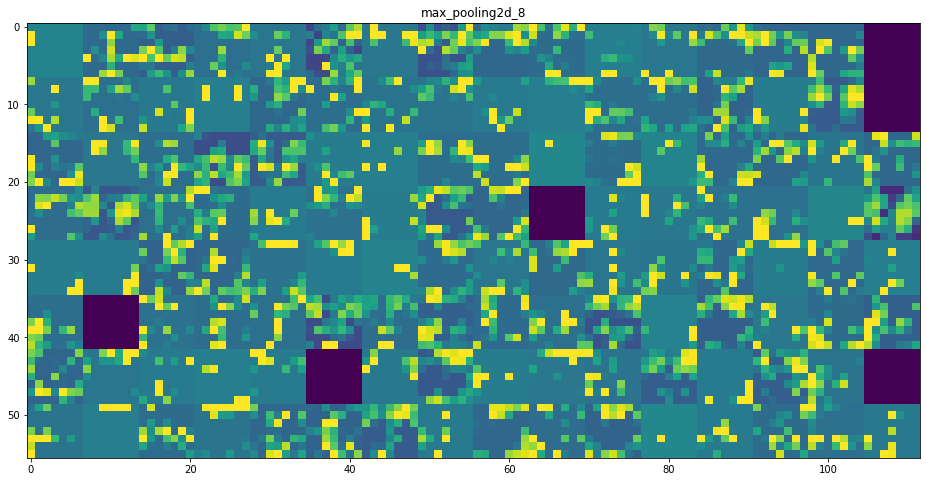

In [6]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    

rows = 16

for name, activation in zip(layer_names, activations):
    n_channels = activation.shape[-1] # number of channels 
    w_channel = activation.shape[1]   # channel's width
    h_channel = activation.shape[2]   # channel's height
    
    cols = n_channels // rows
    display_grid = np.zeros((h_channel * cols, w_channel*rows))
    
    for col in range(cols):
        for row in range(rows):
            channel = activation[0, :, :, row + rows*col]
            
            # z-score
            channel_mean = channel.mean()
            channel_std = channel.std()
            channel -= channel_mean
            channel /= channel_std
            
            # 오른쪽으로 2만큼 이동 후 64 곱해서 0~255로 증폭
            channel += 2
            channel *= 64
            
            # 0~255로 cliping
            channel = np.clip(channel, 0, 255).astype('uint8')
            
            display_grid[col*h_channel : (col+1)*h_channel,
                         row*w_channel : (row+1)*w_channel] = channel
            
        
    scale = 1./w_channel
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### 표준정규분포에서 95%의 데이터만 증폭시키기 (위 코드의 20~29번째 line)

#### line 20~25
- z-score로 변환 $z = \frac{x - \mu}{\sigma}$
- 따라서 **평균 $\mu = 0$, 표준편차 $\sigma = 1$이 됨**

#### line 26~29
- 표준정규분포에서 95%는 표준점수 -1.96\~1.96 구간이므로 약 **-2\~2구간의 데이터**

<img src="./images/data_95percent.png" alt="data_95percent" style="zoom: 50%" align="left" />

- **위 구간(-2, 2) 데이터의 최솟값과 최댓값을 구하고 그 데이터만 0~255로 증폭시켜야 함**


- **-2 지점에서의 최소값 데이터**
    - $z = \frac{x - \mu}{\sigma}$
    - 위 식을 x에 대해 정리하면, 다음과 같다.
    - $x = z \sigma + \mu$에서, 평균 $\mu = 0$, 표준편차 $\sigma = 1$, 표준점수 $z = -2$
    - $\therefore x = -2$
    - **따라서 위 구간 데이터의 최솟값은 -2이다** 
    
    
- **2 지점에서의 최소값 데이터**
    - $z = \frac{x - \mu}{\sigma}$
    - 위 식을 x에 대해 정리하면, 다음과 같다.
    - $x = z \sigma + \mu$에서, 평균 $\mu = 0$, 표준편차 $\sigma = 1$, 표준점수 $z = 2$
    - $\therefore x = 2$
    - **따라서 위 구간 데이터의 최댓값은 2이다**
    

#### 따라서 데이터를 오른쪽으로 2만큼 옮긴 후 전체 데이터에 64를 곱해주면 0~255의 데이터로 증폭됨

### 출력된 특성맵 이미지 분석

- 1번째 층의 출력
    - 여러 종류의 edge 감지를 모아놓은 형태
    - 이 단계에서는 초기 사진에 있는 거의 모든 정보가 유지됨
    

- 상위 층의 출력
    - 상위층으로 갈수록 출력은 점점 더 추상화되어 시각적으로 이해하기 어려워짐(고수준의 개념을 인코딩 함)
    - 이미지의 시각적 콘텐츠에 관한 정보가 줄어들고 클래스에 관한 정보가 점점 증가
    
    
- 비어있는 출력
    - 층이 깊어짐에 따라 비어있는 출력이 늘어남
    - 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않음을 의미
    
    
### 정리
- **특성은 층의 깊이가 깊어짐에 따라 점점 더 추상화됨**
- **높은 층의 출력(활성화)는 특정 입력에 관한 시각적 정보가 점점 줄어들고 타깃에 관한 정보가 점점 더 증가함**
- 심층 신경망은 입력되는 원본 데이터에 대한 반복적인 변환을 통해 관계없는 정보를 걸러내고 유용한 정보는 강조되고 개선시킴

## 5.4.2 컨브넷 필터 시각화하기

### 필터 시각화
- 필터가 반응하는 시각적 패턴을 그리기


### 필터 시각화 과정
- 특정 합성곱 층의 한 필터값을 최대화 하는 손실함수를 정의
- **확률적 경사 상승법**을 적용
    - 경사 하강법과 반대
    - 손실함수의 값이 커지는 방향으로 gradient를 업데이트

### 참고) 그래디언트 클리핑(gradient clipping)
- **gradient(기울기)의 크기가 크지 않도록 제한하는 방법(gradient exploding 방지 기법)**


- 일반적으로 gradient(기울기)가 클 경우 learning rate를 작게 취하는 방법을 사용하는데 이는 큰 gradient 크기를 갖는 상황에서 지나치게 적은 양만 배우므로 훈련 속도가 매우 느려짐


- 즉, gradient의 크기는 계속해서 변하는데 learning rate를 매번 알맞게 최적의 값을 찾아 조절해주는 것은 매우 어려우며 이때 그래디언트 클리핑(gradient clipping)이 매우 유용하게 사용됨


- Adam과 같은 동적인 학습률을 갖는 optimizer를 사용할 경우라면 굳이 그래디언트 클리핑을 적용하지 않아도 괜찮지만 안전장치로 적용하는 것은 좋음

![gradient_clipping](./images/gradient_clipping.png)

- 주로 gradient의 L2 norm이 threshold를 초과할 때, (threshold / L2 norm)을 곱해주는 방법을 사용함
    - L2 norm으로 나눈 gradient의 L2 norm은 1이 됨
    

- `keras.optimizers`모듈의 optimizer를 사용할 때에는 `clipnorm`과 `clipvalue` 매개변수를 설정하면 gradient clipping을 사용할 수 있음
    - `clipnorm` 지정 시
        - `clipnorm` 매개변수의 값이 gradient의 L2 norm보다 클 경우 `clipnorm` 매개변수 값으로 정규화

    - `clipvalue` 지정 시
        - gradient의 최대 절댓값을 `clipvalue`로 제한

    - 둘 모두 적용 시
        - `clipnorm`이 먼저 적용되고 `clipvalue`가 적용됨



#### 참고) `keras.backend.function()`
- 입력 값을 받아 지정된 출력 텐서를 얻을 수 있는 `keras.backend.Function` 객체를 만들어줌

In [7]:
# 경사 상승법 결과 텐서를 이미지 형태로 변환하는 함수

def deprocess_image(x):
    # 평균 0, 표준편차 0.1이 되도록 정규화
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # -0.5 ~ 0.5 구간 데이터만 [0, 1]로 클리핑
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # 0~255데이터로 증폭(RGB 데이터로 변환)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [8]:
from keras import backend as K

def generate_pattern(layer_name, filter_index, size=150):
    # 시각화를 위해 loss 텐서 정의
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # 입력에 대한 loss의 gradient
    grads = K.gradients(loss, model.input)[0]
    
    # gradient clipping
    # 경사 상승법 과정을 부드럽게 하기 위해 L2 norm으로 나누어 정규화
    # divide by 0 방지 : 1e-5
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # iterate
    # 입력 : 모델의 입력 형태인 넘파이 텐서
    #       (shape=(None, None, None, 3), dtype=float32)
    # 출력 : loss, gradient 2개의 넘파이 텐서
    iterate = K.function([model.input], [loss, grads])
    
    
    # 확률적 경사 상승법 40회
    # 입력 이미지는 랜덤한 잡음 섞인 회색 이미지로 시작
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # learning rate
    step = 1.

    for i in range(40):
        # 이미지 입력에 대한 loss 텐서와 gradient 텐서 계산
        loss_value, grads_value = iterate([input_img_data])
            
        # += 연산이 손실을 최대화 하는 방향을 의미 : 경사 상승법
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)

(150, 150, 3)


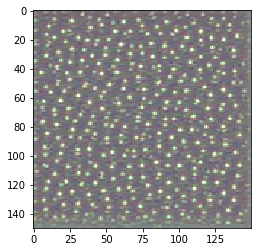

In [9]:
# VGG16의 block3_conv1층의 0번째 필터를 시각화

from keras.applications import VGG16
import matplotlib.pyplot as plt

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

res = generate_pattern(layer_name, filter_index)

print(res.shape)
plt.imshow(res)

- block3_conv1 층의 필터 0은 물방울 패턴에 반응하는 것으로 추정할 수 있음

### 모든 층에 있는 필터를 시각화 해보기
- 각 층의 처음 64개 필터만 시각화
- 각 합성곱 블럭의 1번째 층만 시각화
    - block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1

- 64x64 필터 패턴의 8x8 그리드로 정렬
- 각 필터 사이 검은색 마진

visualizing layer name : block1_conv1
visualizing layer name : block2_conv1
visualizing layer name : block3_conv1
visualizing layer name : block4_conv1
visualizing layer name : block5_conv1


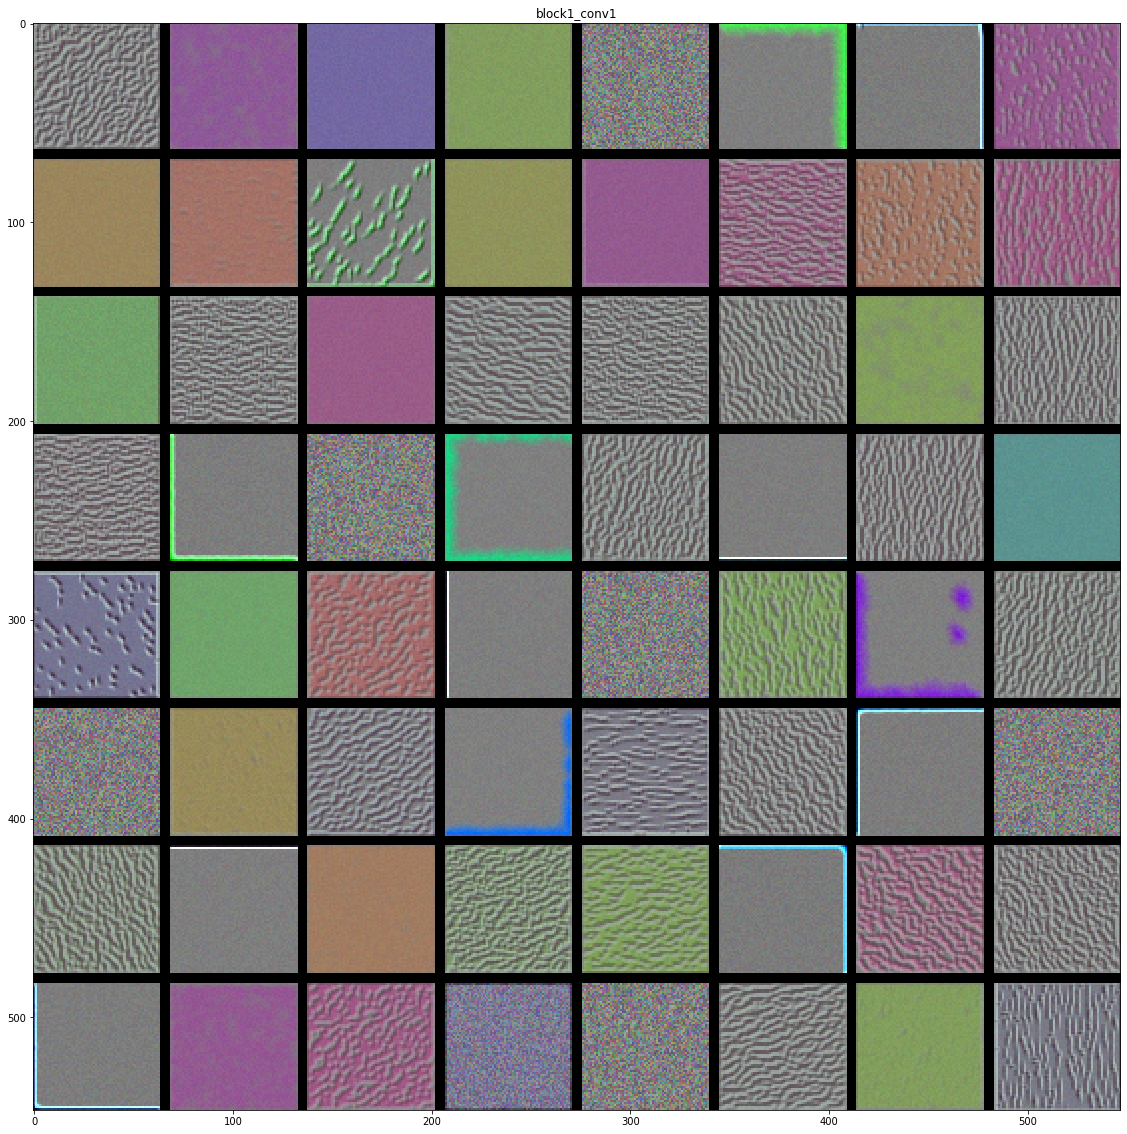

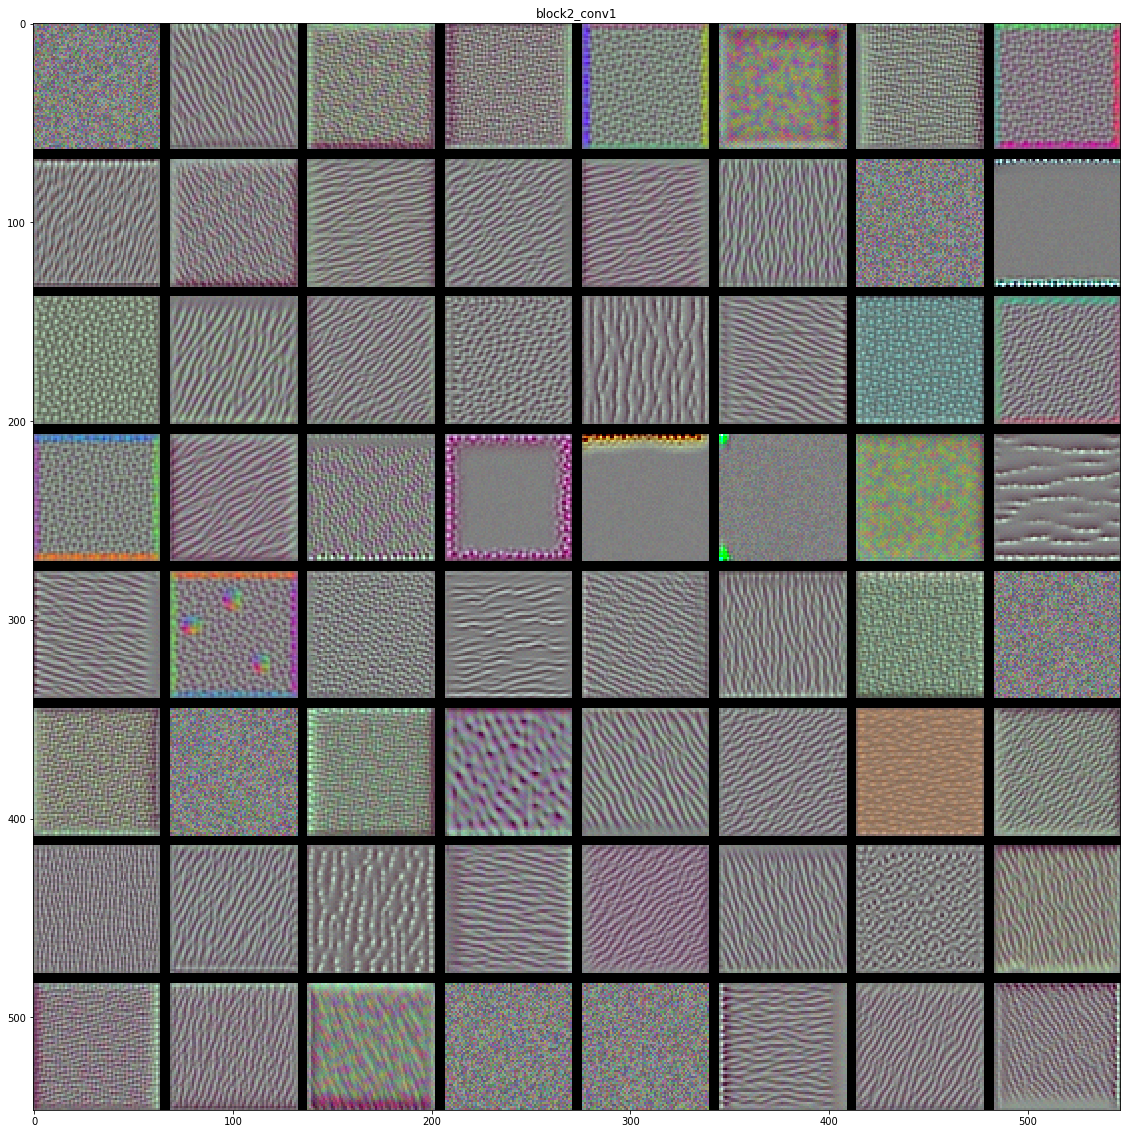

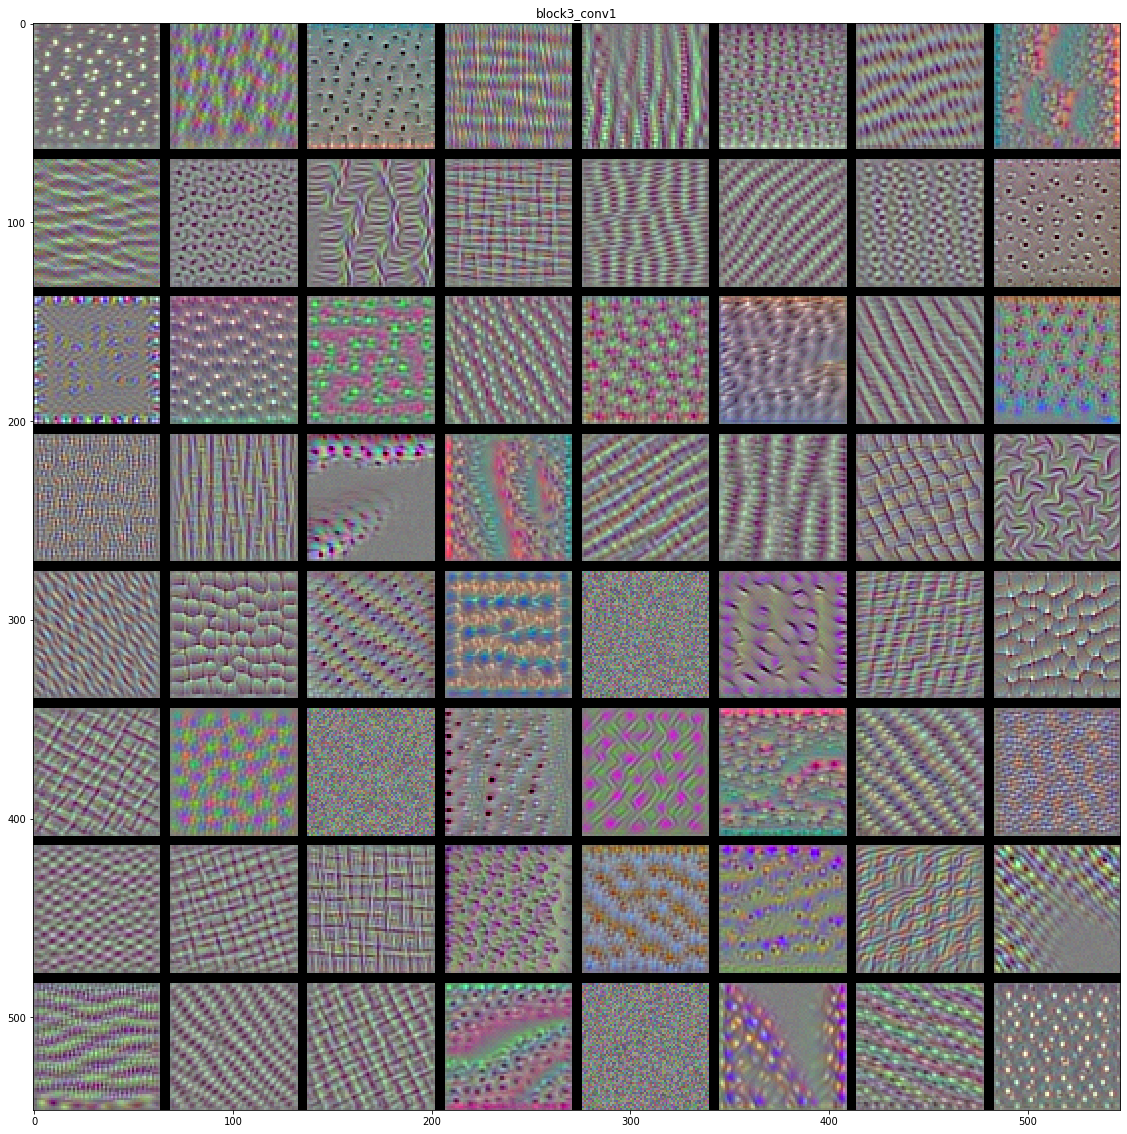

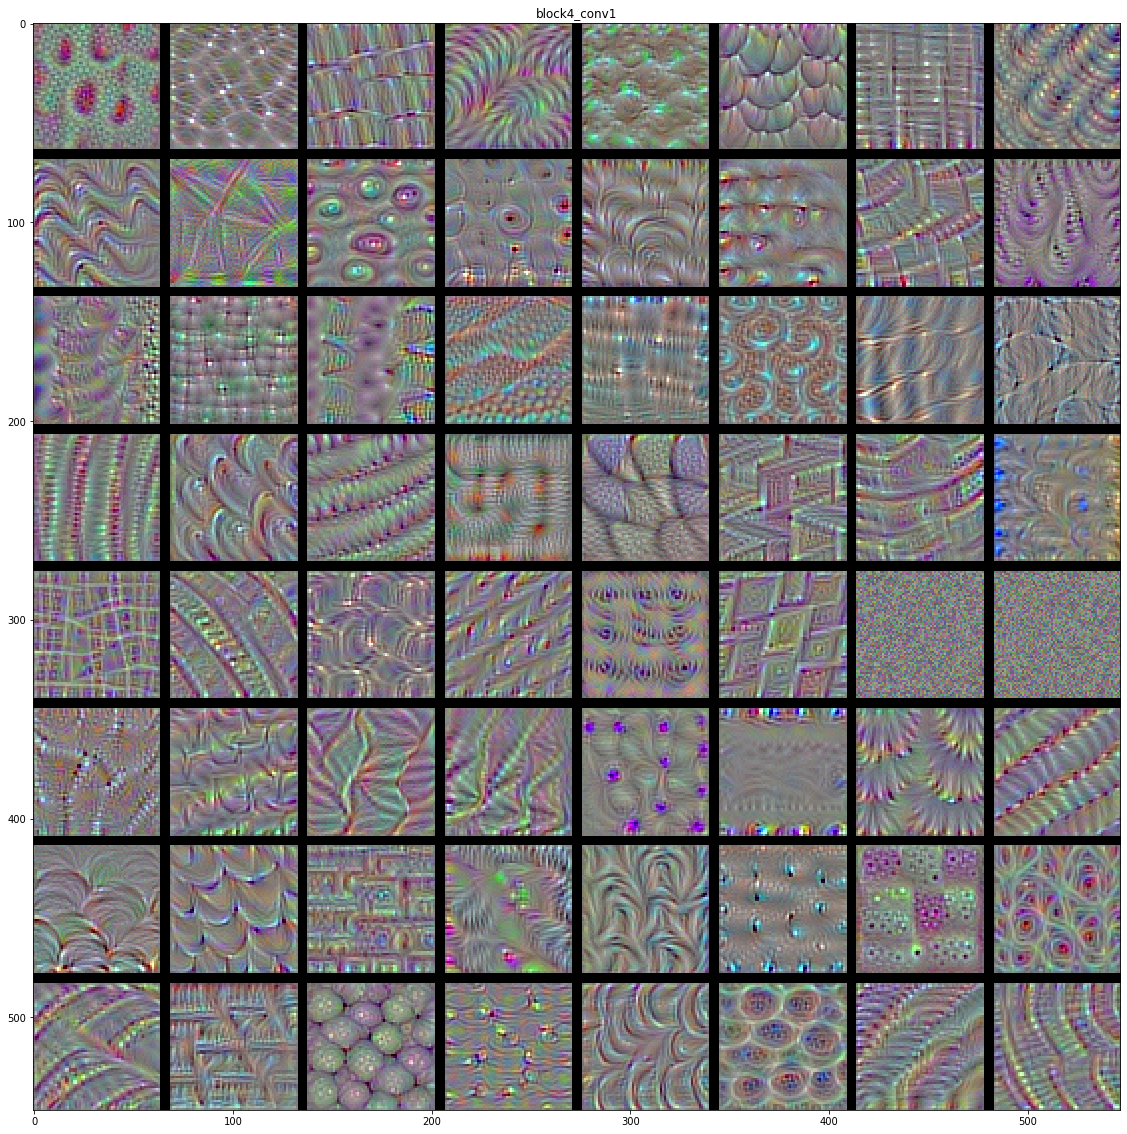

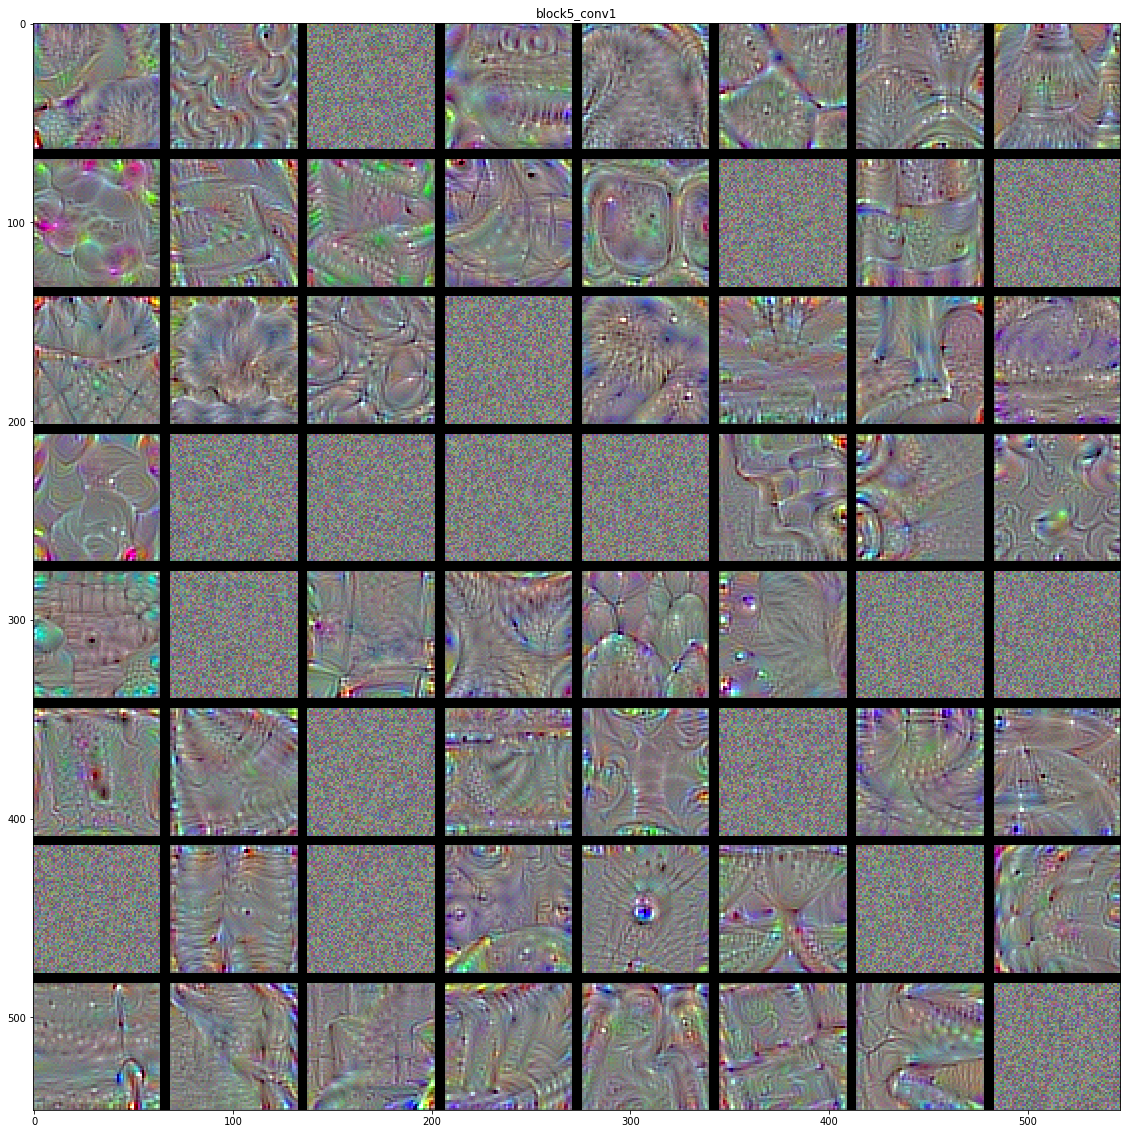

In [10]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
size = 64
margin = 5

for layer_name in layer_names:
    print("visualizing layer name :", layer_name)
    results = np.zeros((8*size + 7*margin, 8*size + 7*margin, 3), dtype='uint8')

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i+(j*8), size=size)

            horizontal_start = i*size + i*margin
            horizontal_end = horizontal_start + size

            vertical_start = j*size + j*margin
            vertical_end = vertical_start + size

            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img


    plt.figure(figsize=(20, 20))
    plt.title(layer_name)
    plt.imshow(results)

    
plt.show()

### 필터 시각화를 통한 Convnet의 이해

- **Convnet의 각 층은 필터의 조합으로 입력으로 표현할 수 있는 일련의 필터를 학습함**
- 푸리에 변환(Fourier transform)을 사용해 신호를 코사인 함수로 분해할 수 있는 것과 비슷
- **상위 층으로 갈수록 더 복잡해지고 개선됨**
    - block1_conv1의 필터는 간단한 edge와 색깔을 인코딩
    - block2_conv1의 필터는 edge나 색깔의 조합으로 만들어진 질감을 인코딩
    - 더 상위 층의 필터로 갈수록 깃털, 눈, 나뭇잎 등 자연적 이미지에서 찾을 수 있는 질감을 닮아감

## 5.4.3 클래스 활성화의 히트맵 시각화하기

### 클래스 활성화 맵 시각화
- 클래스 활성화 맵(Class Activation Map, CAM) 시각화는 입력 이미지에 대한 클래스 활성화의 히트맵을 만듦
- 클래스 활성화의 히트맵은 특정 출력 클래스에 대해 입력 이미지의 모든 위치를 계산한 2D 점수 그리드를 뜻함


### CAM 시각화의 장점
- CAM 시각화를 통해서 이미지의 어느 부분이 convnet의 분류 결정에 기여하는지 알 수 있음
- convnet의 결정 과정을 디버깅 할 수 있음
- 이미지에 특정 물체가 있는 위치를 파악할 수 있음


### CAM 시각화의 구현 
- 여기서는 **Grad-CAM** 알고리즘을 사용해 시각화를 구현
- 구현의 자세한 내용은 ["Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"](https://arxiv.org/abs/1610.02391)에 기술되어 있음
- 간단히 설명하자면 '입력 이미지가 각 채널을 활성화하는 정도'에 대한 공간적인 맵을 '클래스에 대한 각 채널의 중요도'로 가중치를 부여하여 '입력 이미지가 클래스를 활성화하는 정도'에 대한 공간적인 맵을 만드는 것

**Grad-CAM의 구현 방법**
1. 입력 이미지가 주어지면 합성곱 층에 있는 특성 맵의 출력을 추출
2. 특성 맵의 모든 채널 출력에 대한 클래스의 그래디언트 평균을 곱함

In [11]:
# 최상단 분류기도 같이 포함해서 VGG 가져오기

from keras.applications import VGG16

model = VGG16(weights='imagenet')

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# VGG16의 형식에 맞게 데이터 전처리
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './datasets/africa_elephant.jpg'

# 이미지 크기 224 x 224로 변경해서 불러오기
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# vgg16모델에 맞게 채널별 컬러 정규화 수행
x = preprocess_input(x)

In [13]:
# 모델에 사진 넣고 예측
preds = model.predict(x)

# 결과 출력
# decode_predictions는 예측 결과를 이해하기 쉽게 디코딩 해줌
# (top=3라서 1~3위 결과 출력)

print('Predicted Result')
print("1st :", decode_predictions(preds, top=3)[0][0])
print("2nd :", decode_predictions(preds, top=3)[0][1])
print("3rd :", decode_predictions(preds, top=3)[0][2])

Predicted Result
1st : ('n02504458', 'African_elephant', 0.88340753)
2nd : ('n01871265', 'tusker', 0.10077613)
3rd : ('n02408429', 'water_buffalo', 0.008631054)


In [14]:
# 가장 높은 확률인 아프리카 코끼리 클래스의 인덱스 출력
print(np.argmax(preds))

386


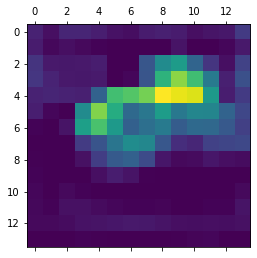

In [15]:
import keras.backend as K
import matplotlib.pyplot as plt

# Grad-CAM 알고리즘

african_elephant_output = model.output[:, 386]

# 모델의 마지막 convolutaion layer인 block5_conv3
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 'African_elephant' class의 gradient
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균값이 담긴 (512,)크기의 벡터 (채널(필터)이 512개)
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지를 input으로 pooled_grads와 block5_conv3의 특성 맵을 출력
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵
heatmap = np.mean(conv_layer_output_value, axis=-1)

# 히트맵 후처리
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [16]:
# opencv를 이용해 원본 이미지에 heatmap을 겹친 이미지 출력

import cv2

img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# RGB 포맷으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4의 히트맵 강도
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./datasets/africa_elephant_cam.jpg', superimposed_img)

True

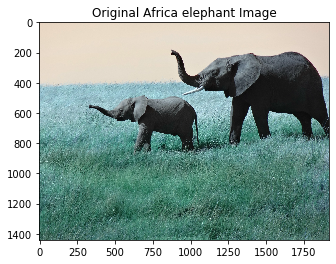

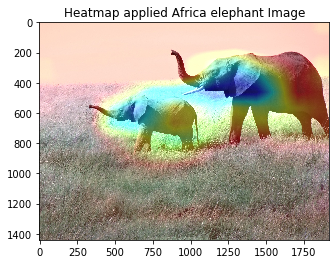

In [18]:
origin = cv2.imread('./datasets/africa_elephant.jpg')
origin = np.array(origin).astype('float32') / 255.

result = cv2.imread('./datasets/africa_elephant_cam.jpg')
result = np.array(result).astype('float32') / 255.

plt.figure()
plt.title("Original Africa elephant Image")
plt.imshow(origin)

plt.figure()
plt.title("Heatmap applied Africa elephant Image")
plt.imshow(result)

**결과 분석**
- 코끼리의 귀가 강하게 활성화 된 것을 보아 코끼리의 귀를 통해 네트워크가 아프리카 코끼리를 분류한다는 것을 알 수 있음